In [1]:
import xarray as xr
import jsmetrics as js
from pathlib import Path

import functions.data_wrangling as data
import functions.eddy_feedback as ef

import warnings
warnings.filterwarnings("ignore", category=xr.SerializationWarning)

# Data setup

#### Set paths, find model names and import data

In [22]:
data_path = Path('/home/links/ct715/data_storage/PAMIP/monthly')
pres_path = data_path / '1.1_pdSST-pdSIC/combined_ua_epfy_divFy' 
fut_path = data_path / '1.6_pdSST-futArcSIC/combined_ua_epfy_divFy' 

list_dir = fut_path.iterdir()
model_list = [item.name for item in list_dir]
model_list.sort()

In [23]:
# model_list.remove('OpenIFS-511')
model_list.remove('OpenIFS-159')
model_list.remove('CESM1-WACCM-SC')
model_list.remove('EC-EARTH3')
model_list.remove('CNRM-CM6-1')
model_list.remove('IPSL-CM6A-LR')

model_list

['CESM2',
 'CanESM5',
 'FGOALS-f3-L',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'MIROC6',
 'NorESM2-LM']

In [24]:
pres, fut = {}, {}
for model in model_list:
    print(model)
    # import present day datasets and take winter mean
    try:
        ds_pres = xr.open_mfdataset(
            str(pres_path / f'{model}/*.nc'),
            #parallel=True,
            combine='nested',
            concat_dim='ens_ax',
            chunks={'time': 31},
            engine='netcdf4'
        )
    except KeyError as e:
        print(e)
    # pres[model] = data.seasonal_mean(ds_pres, season='djf')
    pres[model] = ds_pres.load()
    
    # import futArc datasets and take winter mean
    try:
        ds_fut = xr.open_mfdataset(
            str(fut_path / f'{model}/*.nc'),
            #parallel=True,
            combine='nested',
            concat_dim='ens_ax',
            chunks={'time': 31},
            engine='netcdf4'
        )
    except KeyError as e:
        print(e)
    # fut[model] = data.seasonal_mean(ds_fut, season='djf')
    fut[model] = ds_fut.load()

CESM2
CanESM5
FGOALS-f3-L
HadGEM3-GC31-LL
HadGEM3-GC31-MM
MIROC6
NorESM2-LM


In [25]:
efp_pres, efp_fut = {}, {}
for model in model_list:
    
    efp_value_pres = ef.calculate_efp(pres[model], data_type='pamip')
    efp_value_fut = ef.calculate_efp(fut[model], data_type='pamip')
    
    efp_pres[model] = efp_value_pres
    efp_fut[model] = efp_value_fut

In [26]:
for model in model_list:
    print(f'{model} pres: {efp_pres[model]}')
    print(f'{model} fut: {efp_fut[model]}')

CESM2 pres: 0.3693
CESM2 fut: 0.3368
CanESM5 pres: 0.4256
CanESM5 fut: 0.4689
FGOALS-f3-L pres: 0.2354
FGOALS-f3-L fut: 0.2465
HadGEM3-GC31-LL pres: 0.273
HadGEM3-GC31-LL fut: 0.3395
HadGEM3-GC31-MM pres: 0.3137
HadGEM3-GC31-MM fut: 0.0097
MIROC6 pres: 0.2213
MIROC6 fut: nan
NorESM2-LM pres: 0.3238
NorESM2-LM fut: 0.3685


# Regional plots

In [27]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

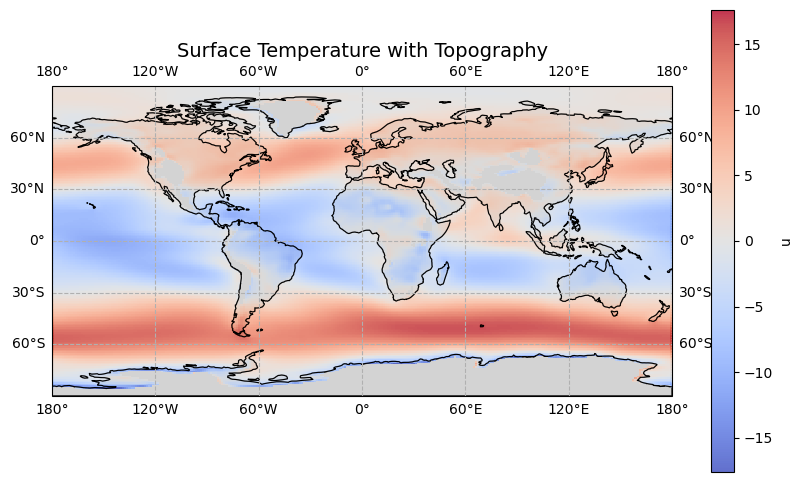

In [28]:
# Load dataset
ua850 = fut[model_list[0]]['u'].sel(level=850).mean(('time', 'ens_ax'))

# Create the plot
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}  # Use PlateCarree for lat/lon data
)

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')  # Default land feature

# Overlay surface temperature
ua850.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    alpha=0.8,  # Transparency for blending
    add_colorbar=True
)

# Add gridlines and coastlines
ax.coastlines(resolution='110m', color='black', linewidth=0.8)
ax.gridlines(draw_labels=True, linestyle='--')

# Add a title
plt.title("Surface Temperature with Topography", fontsize=14)
plt.show()

### North Atlantic

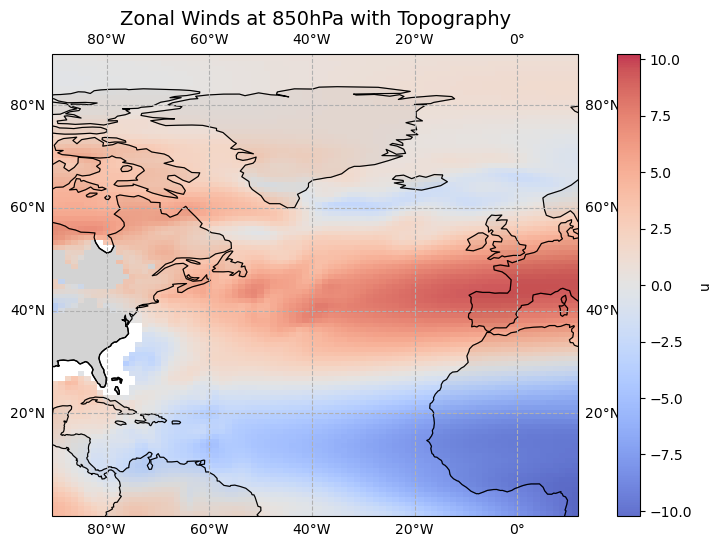

In [29]:
# Adjust longitudes to -180 to 180 range
ua850_lon = ua850.assign_coords(lon=ua850.lon - 180)
# Subset longitude for 280W-360W (-80 to 0) and 0E-12E
ua850_lon1 = ua850_lon.sel(lon=slice(-90,12)) 
ua850_natl = ua850_lon1.sel(lat=slice(0, 90))

# Create the plot
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}  # Use PlateCarree for lat/lon data
)

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')  # Default land feature

# Overlay zonal wind at 850hPa
ua850_natl.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    alpha=0.8,  # Transparency for blending
    add_colorbar=True
)

# Add gridlines and coastlines
ax.coastlines(resolution='110m', color='black', linewidth=0.8)
ax.gridlines(draw_labels=True, linestyle='--')

# Add a title
plt.title("Zonal Winds at 850hPa with Topography", fontsize=14)
plt.show()

### North Pacific

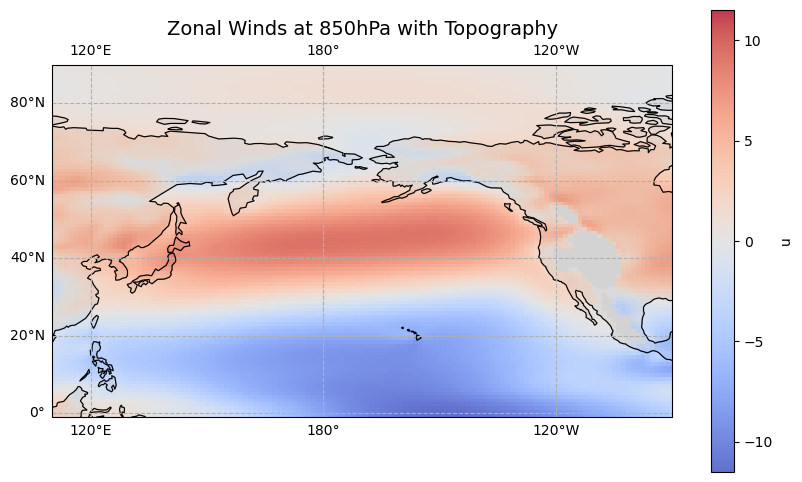

In [30]:
# define NH
ua850_npac = ua850.sel(lat=slice(-1, 90))
ua850_npac = ua850_npac.sel(lon=slice(110,270)) 


# Create the plot
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}  # Use PlateCarree for lat/lon data
)

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')  # Default land feature

# Overlay zonal wind at 850hPa
ua850_npac.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    alpha=0.8,  # Transparency for blending
    add_colorbar=True
)

# Set the extent to avoid grey space
ax.set_extent([110, 270, -1, 90], crs=ccrs.PlateCarree())  # [lon_min, lon_max, lat_min, lat_max]

# Add gridlines and coastlines
ax.coastlines(resolution='110m', color='black', linewidth=0.8)
ax.gridlines(draw_labels=True, linestyle='--')

# Add a title
plt.title("Zonal Winds at 850hPa with Topography", fontsize=14)
plt.show()

# Jet shift calculations

## North Atlantic

In [31]:
# model-specific changes
# fut[model_list[6]]['ubar'] = fut[model_list[6]].ua.mean('lon')
# fut[model_list[6]] = fut[model_list[6]][['ubar', 'epfy', 'divF']]

jets_pres_natl, jets_fut_natl = {}, {}
for model in model_list:
    
    # rename vars for jsmetrics
    pres_model_natl = pres[model].rename({'level': 'plev', 'u': 'ua'})
    fut_model_natl = fut[model].rename({'level': 'plev', 'u': 'ua'})
    
    # one model ensemble members is done by time rather than ens_ax
    if 'ens_ax' in pres_model_natl.dims:
        pres_model_natl = pres_model_natl.mean('ens_ax')
        fut_model_natl = fut_model_natl.mean('ens_ax')
    else:
        pres_model_natl = pres_model_natl.groupby('time.month').mean('time')
        pres_model_natl = pres_model_natl.rename({'month': 'time'})
        fut_model_natl = fut_model_natl.groupby('time.month').mean('time')
        fut_model_natl = fut_model_natl.rename({'month': 'time'})
        
    # subset data to consistency 
    pres_model_natl, fut_model_natl = pres_model_natl.sel(plev=850.), fut_model_natl.sel(plev=850.)
    pres_model_natl, fut_model_natl = pres_model_natl.sel(lat=slice(30,70)), fut_model_natl.sel(lat=slice(30,70))
    
    # subset datasets for north atlantic region
    pres_model_natl = pres_model_natl.assign_coords(lon=pres_model_natl.lon - 180)
    fut_model_natl = fut_model_natl.assign_coords(lon=fut_model_natl.lon - 180)
    pres_model_natl, fut_model_natl = pres_model_natl.sel(lon=slice(-90,12)), fut_model_natl.sel(lon=slice(-90,12))
        
    # Add the longitude coordinate
    # lon = xr.DataArray([0], dims="lon", coords={"lon": [0]})
    # pres_model_natl = xr.concat([pres_model_natl], dim=lon)
    pres_model_natl = js.jet_statistics.zappa_et_al_2018(pres_model_natl)
    # fut_model_natl = xr.concat([fut_model_natl], dim=lon)
    fut_model_natl = js.jet_statistics.zappa_et_al_2018(fut_model_natl)
    
    # pres_model_natl = convert_to_360_day_calendar(pres_model_natl)
    
    jets_pres_natl[model] = pres_model_natl
    jets_fut_natl[model] = fut_model_natl

In [35]:
import numpy as np

In [36]:
diff_natl = {}
for model in model_list:
    
    # take diffference of jet latitudes
    difference_natl = jets_fut_natl[model].jet_lat - jets_pres_natl[model].jet_lat
    diff_natl[model] = np.mean(difference_natl.values)

In [37]:
diff_natl

{'CESM2': -0.3397025656645975,
 'CanESM5': -0.003340058363391426,
 'FGOALS-f3-L': -0.15700433924419066,
 'HadGEM3-GC31-LL': -0.2682712418310326,
 'HadGEM3-GC31-MM': -0.1278552509910611,
 'MIROC6': -0.26289955917003266,
 'NorESM2-LM': -0.31548076438964107}

### Plot the data

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy as sp

In [39]:
jet_shifts_natl = pd.DataFrame.from_dict(diff_natl, orient='index', columns=['jet_shift_natl']).reset_index()
jet_shifts_natl.rename(columns={'index': 'model'}, inplace=True)
# Add the dictionary as a new column
jet_shifts_natl['efp_value'] = jet_shifts_natl.model.map(efp_pres)
jet_shifts_natl

,model,jet_shift_natl,efp_value
0,CESM2,-0.339703,0.3693
1,CanESM5,-0.003340,0.4256
2,FGOALS-f3-L,-0.157004,0.2354
3,HadGEM3-GC31-LL,-0.268271,0.2730
4,HadGEM3-GC31-MM,-0.127855,0.3137
5,MIROC6,-0.262900,0.2213
6,NorESM2-LM,-0.315481,0.3238


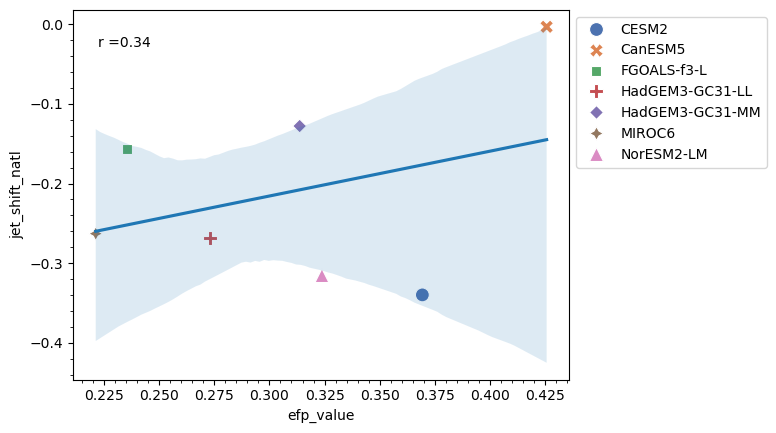

In [41]:
plt.figure()
# sns.regplot(data=jet_shifts, x='efp_value', y='jet_shift', scatter_kws={'color': 'white'}, line_kws={"color": "gray"})
scatter_plot = sns.scatterplot(
    x='efp_value', 
    y='jet_shift_natl', 
    hue='model', 
    style='model', 
    data=jet_shifts_natl, 
    palette='deep', 
    markers=True, 
    s=100
)

# Plot the regression line
sns.regplot(
    x='efp_value', 
    y='jet_shift_natl', 
    data=jet_shifts_natl, 
    scatter=False, 
    ax=scatter_plot
)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=jet_shifts_natl['efp_value'], y=jet_shifts_natl['jet_shift_natl'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)

# plt.xlim([0,0.5])
# plt.ylim([0,0.5])

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## North Pacific

In [47]:
# model-specific changes
# fut[model_list[6]]['ubar'] = fut[model_list[6]].ua.mean('lon')
# fut[model_list[6]] = fut[model_list[6]][['ubar', 'epfy', 'divF']]

jets_pres_npac, jets_fut_npac = {}, {}
for model in model_list:
    
    # rename vars for jsmetrics
    pres_model_npac = pres[model].rename({'level': 'plev', 'u': 'ua'})
    fut_model_npac = fut[model].rename({'level': 'plev', 'u': 'ua'})
    
    # one model ensemble members is done by time rather than ens_ax
    if 'ens_ax' in pres_model_npac.dims:
        pres_model_npac = pres_model_npac.mean('ens_ax')
        fut_model_npac = fut_model_npac.mean('ens_ax')
    else:
        pres_model_npac = pres_model_npac.groupby('time.month').mean('time')
        pres_model_npac = pres_model_npac.rename({'month': 'time'})
        fut_model_npac = fut_model_npac.groupby('time.month').mean('time')
        fut_model_npac = fut_model_npac.rename({'month': 'time'})
        
    # subset data to consistency 
    pres_model_npac, fut_model_npac = pres_model_npac.sel(plev=850.), fut_model_npac.sel(plev=850.)
    pres_model_npac, fut_model_npac = pres_model_npac.sel(lat=slice(30,70)), fut_model_npac.sel(lat=slice(30,70))
    
    # subset datasets for north atlantic region
    pres_model_npac = pres_model_npac.assign_coords(lon=pres_model_npac.lon - 180)
    fut_model_npac = fut_model_npac.assign_coords(lon=fut_model_npac.lon - 180)
    pres_model_npac, fut_model_npac = pres_model_npac.sel(lon=slice(-90,12)), fut_model_npac.sel(lon=slice(110,270))
        
    # Add the longitude coordinate
    # lon = xr.DataArray([0], dims="lon", coords={"lon": [0]})
    # pres_model_npac = xr.concat([pres_model_npac], dim=lon)
    pres_model_npac = js.jet_statistics.zappa_et_al_2018(pres_model_npac)
    # fut_model_npac = xr.concat([fut_model_npac], dim=lon)
    fut_model_npac = js.jet_statistics.zappa_et_al_2018(fut_model_npac)
    
    # pres_model_npac = convert_to_360_day_calendar(pres_model_npac)
    
    jets_pres_npac[model] = pres_model_npac
    jets_fut_npac[model] = fut_model_npac

In [48]:
diff_npac = {}
for model in model_list:
    
    # take diffference of jet latitudes
    difference_npac = jets_fut_npac[model].jet_lat - jets_pres_npac[model].jet_lat
    diff_npac[model] = np.mean(difference_npac.values)

In [49]:
diff_npac

{'CESM2': 4.300901474580334,
 'CanESM5': 4.535855968562794,
 'FGOALS-f3-L': 3.21901835732354,
 'HadGEM3-GC31-LL': 3.6364404897487863,
 'HadGEM3-GC31-MM': 3.95479949193463,
 'MIROC6': 3.980218064774615,
 'NorESM2-LM': 2.8007861403004815}

### Plot the data

In [50]:
jet_shifts_npac = pd.DataFrame.from_dict(diff_npac, orient='index', columns=['jet_shift_npac']).reset_index()
jet_shifts_npac.rename(columns={'index': 'model'}, inplace=True)
# Add the dictionary as a new column
jet_shifts_npac['efp_value'] = jet_shifts_npac.model.map(efp_pres)
jet_shifts_npac

,model,jet_shift_npac,efp_value
0,CESM2,4.300901,0.3693
1,CanESM5,4.535856,0.4256
2,FGOALS-f3-L,3.219018,0.2354
3,HadGEM3-GC31-LL,3.636440,0.2730
4,HadGEM3-GC31-MM,3.954799,0.3137
5,MIROC6,3.980218,0.2213
6,NorESM2-LM,2.800786,0.3238


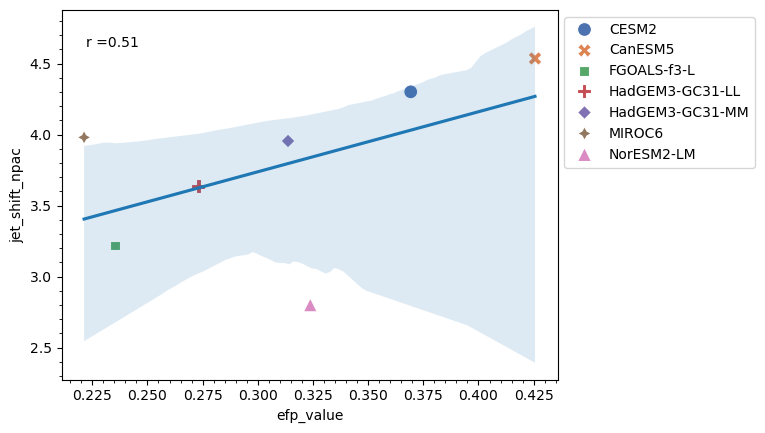

In [51]:
plt.figure()
# sns.regplot(data=jet_shifts, x='efp_value', y='jet_shift', scatter_kws={'color': 'white'}, line_kws={"color": "gray"})
scatter_plot = sns.scatterplot(
    x='efp_value', 
    y='jet_shift_npac', 
    hue='model', 
    style='model', 
    data=jet_shifts_npac, 
    palette='deep', 
    markers=True, 
    s=100
)

# Plot the regression line
sns.regplot(
    x='efp_value', 
    y='jet_shift_npac', 
    data=jet_shifts_npac, 
    scatter=False, 
    ax=scatter_plot
)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=jet_shifts_npac['efp_value'], y=jet_shifts_npac['jet_shift_npac'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)

# plt.xlim([0,0.5])
# plt.ylim([0,0.5])

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.show()